# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [11]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  print "X_train.shape = ", X_train.shape
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  print "X_val.shape = ", X_val.shape
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

X_train.shape =  (50000, 32, 32, 3)
X_val.shape =  (1000, 32, 32, 3)
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.315434
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** The Softmax cross-entropy loss for one sample i is Li = -fyi + log(sum(exp(fj))) (with no regularization as above). Weights are random here and small with no learning, so we can assume that fyi, fj have "probability" scores evenly distributed (equal values) near the maximum score for all classes (e.g., fyi, fj = 0 after numerical stabilization hack). This leads to Li = log(10) = -0 + log(10) = -log(0.1) 


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.663177 analytic: 0.663177, relative error: 1.295740e-07
numerical: -0.096870 analytic: -0.096870, relative error: 1.460272e-07
numerical: 0.119171 analytic: 0.119170, relative error: 3.125107e-07
numerical: -2.426028 analytic: -2.426028, relative error: 2.259999e-09
numerical: 1.024336 analytic: 1.024336, relative error: 3.923149e-08
numerical: 0.610333 analytic: 0.610333, relative error: 4.527621e-08
numerical: -0.885311 analytic: -0.885311, relative error: 4.876235e-08
numerical: -1.301939 analytic: -1.301939, relative error: 4.924327e-08
numerical: 0.729143 analytic: 0.729143, relative error: 4.659943e-08
numerical: -2.831723 analytic: -2.831723, relative error: 2.339785e-08
numerical: -2.307359 analytic: -2.307427, relative error: 1.481191e-05
numerical: 2.758984 analytic: 2.766992, relative error: 1.449156e-03
numerical: -1.346374 analytic: -1.337680, relative error: 3.239275e-03
numerical: -1.057703 analytic: -1.044096, relative error: 6.474064e-03
numerical: -2.0293

In [13]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.345138e+00 computed in 0.180222s
vectorized loss: 2.345138e+00 computed in 0.132470s
Loss difference: 0.000000
Gradient difference: 0.000000


In [18]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [5e-6]  # original [5e-8, 1e-7], final test [5e-6, 1e-5, 5e-5]
regularization_strengths = [1e7]  # original [5e4, 1e8], final test [1e3, 5e4, 1e5, 1e6, 1e7, 1e8, 1e9]

#lr 5.000000e-06 reg 1.000000e+03 train accuracy: 0.372714 val accuracy: 0.356000
#lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.383531 val accuracy: 0.358000
#lr 5.000000e-06 reg 1.000000e+05 train accuracy: 0.389122 val accuracy: 0.370000
#lr 5.000000e-06 reg 1.000000e+06 train accuracy: 0.383980 val accuracy: 0.352000
#lr 5.000000e-06 reg 1.000000e+07 train accuracy: 0.396265 val accuracy: 0.393000
#lr 5.000000e-06 reg 1.000000e+08 train accuracy: 0.398551 val accuracy: 0.388000
#lr 5.000000e-06 reg 1.000000e+09 train accuracy: 0.395857 val accuracy: 0.386000
#lr 1.000000e-05 reg 1.000000e+03 train accuracy: 0.342980 val accuracy: 0.330000
#lr 1.000000e-05 reg 5.000000e+04 train accuracy: 0.325592 val accuracy: 0.294000
#lr 1.000000e-05 reg 1.000000e+05 train accuracy: 0.308367 val accuracy: 0.265000
#lr 1.000000e-05 reg 1.000000e+06 train accuracy: 0.339388 val accuracy: 0.310000
#lr 1.000000e-05 reg 1.000000e+07 train accuracy: 0.320102 val accuracy: 0.294000
#lr 1.000000e-05 reg 1.000000e+08 train accuracy: 0.325245 val accuracy: 0.296000
#lr 1.000000e-05 reg 1.000000e+09 train accuracy: 0.316694 val accuracy: 0.299000
#lr 5.000000e-05 reg 1.000000e+03 train accuracy: 0.314796 val accuracy: 0.309000
#lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.291510 val accuracy: 0.291000
#lr 5.000000e-05 reg 1.000000e+05 train accuracy: 0.269429 val accuracy: 0.263000
#lr 5.000000e-05 reg 1.000000e+06 train accuracy: 0.262265 val accuracy: 0.261000
#lr 5.000000e-05 reg 1.000000e+07 train accuracy: 0.312673 val accuracy: 0.292000
#lr 5.000000e-05 reg 1.000000e+08 train accuracy: 0.323408 val accuracy: 0.307000
#lr 5.000000e-05 reg 1.000000e+09 train accuracy: 0.285551 val accuracy: 0.253000
#best validation accuracy achieved during cross-validation: 0.393000

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
iters_valtune = 1500   # num_iters=1500
for lr_val in learning_rates:
    for reg_val in regularization_strengths:
        softmax_test = Softmax()
        loss_hist_temp = softmax_test.train(X_train, y_train, lr_val, reg_val,
                      iters_valtune, verbose=False)
        y_train_pred_temp = softmax_test.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred_temp)
        # print 'training accuracy: %f' % (train_acc, )
        y_val_pred_temp = softmax_test.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred_temp)
        # print 'validation accuracy: %f' % (val_acc, )
        results[(lr_val,reg_val)] = (train_acc,val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax_test
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 5.000000e-06 reg 1.000000e+07 train accuracy: 0.395061 val accuracy: 0.370000
best validation accuracy achieved during cross-validation: 0.370000


In [19]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.376000


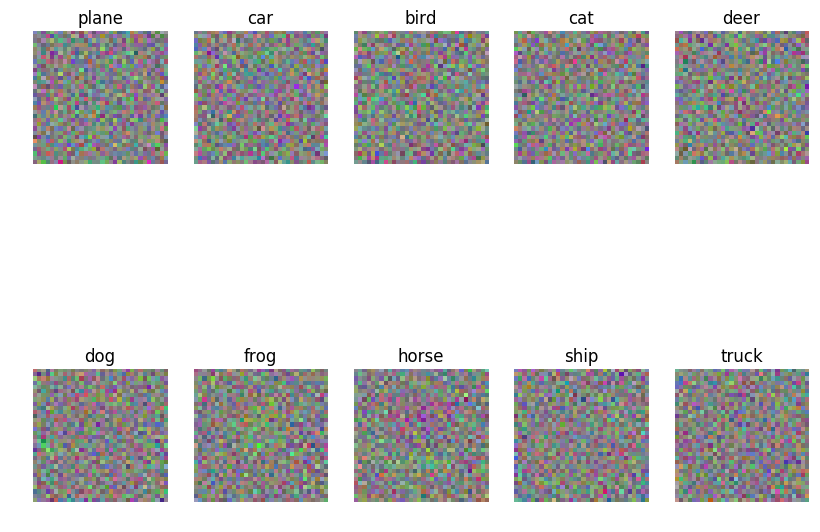

In [20]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])